In [ ]:
def parse_data(file_path):
    """Parse the customer data from the provided file."""
    with open(file_path, 'r') as f:
        lines = f.readlines()

    # Afficher les premières lignes pour vérifier le format
    print("First few lines of the file:")
    print(lines[:10])  # Afficher les 10 premières lignes pour déboguer

    # Vérifier si les lignes sont suffisantes
    if len(lines) < 6:
        raise ValueError("Le fichier ne contient pas assez de données")

    # Rechercher la ligne qui contient "VEHICLE"
    vehicle_index = next(i for i, line in enumerate(lines) if "VEHICLE" in line)
    # La capacité des véhicules se trouve deux lignes après "VEHICLE"
    try:
        vehicle_capacity = int(lines[vehicle_index + 2].split()[-1])  # Get vehicle capacity
    except IndexError:
        raise ValueError("Impossible de récupérer la capacité du véhicule à partir de la ligne attendue")

    customer_data = []

    # Rechercher la ligne qui contient "CUSTOMER" pour savoir où commencer
    customer_index = next(i for i, line in enumerate(lines) if "CUSTOMER" in line)
    
    # Extraire les données des clients à partir de la ligne suivante
    for line in lines[customer_index + 2:]:  # Commencer après l'entête "CUSTOMER"
        if line.strip():  # Si la ligne n'est pas vide
            data = line.split()
            if len(data) == 7:  # Vérifier qu'il y a bien 7 éléments sur la ligne
                customer_data.append({
                    'id': int(data[0]),
                    'x': float(data[1]),
                    'y': float(data[2]),
                    'demand': int(data[3]),
                    'ready_time': int(data[4]),
                    'due_date': int(data[5]),
                    'service_time': int(data[6])
                })
            else:
                print(f"Skipping invalid line: {line.strip()}")  # Afficher les lignes mal formatées

    return vehicle_capacity, customer_data

# Exemple de test
vehicle_capacity, customer_data = parse_data("../Dataset/c102.txt")

print(f"Vehicle Capacity: {vehicle_capacity}")
print(f"Customer Data: {customer_data}")


First few lines of the file:
['C102\n', '\n', 'VEHICLE\n', 'NUMBER     CAPACITY\n', '  25         200\n', '\n', 'CUSTOMER\n', 'CUST NO.  XCOORD.   YCOORD.    DEMAND   READY TIME  DUE DATE   SERVICE   TIME\n', ' \n', '    0      40         50          0          0       1236          0   \n']
Vehicle Capacity: 200
Customer Data: [{'id': 0, 'x': 40.0, 'y': 50.0, 'demand': 0, 'ready_time': 0, 'due_date': 1236, 'service_time': 0}, {'id': 1, 'x': 45.0, 'y': 68.0, 'demand': 10, 'ready_time': 0, 'due_date': 1127, 'service_time': 90}, {'id': 2, 'x': 45.0, 'y': 70.0, 'demand': 30, 'ready_time': 0, 'due_date': 1125, 'service_time': 90}, {'id': 3, 'x': 42.0, 'y': 66.0, 'demand': 10, 'ready_time': 0, 'due_date': 1129, 'service_time': 90}, {'id': 4, 'x': 42.0, 'y': 68.0, 'demand': 10, 'ready_time': 727, 'due_date': 782, 'service_time': 90}, {'id': 5, 'x': 42.0, 'y': 65.0, 'demand': 10, 'ready_time': 0, 'due_date': 1130, 'service_time': 90}, {'id': 6, 'x': 40.0, 'y': 69.0, 'demand': 20, 'ready_time'


Optimized Results:
Number of Trucks Used: 8

Truck 1 path: Depot -> 57 -> 0 -> 41 -> 6 -> 69 -> 10 -> 96 -> 4 -> 64 -> 88 -> 5 -> 37 -> 72 -> 40 -> 62 -> 34 -> 77 -> Depot
  Cost (Distance): 478.40 units
  Weight of goods when leaving depot: 196 units
  Weight of goods when returning to depot: 0 units

Truck 2 path: Depot -> 20 -> 11 -> 89 -> 74 -> 73 -> 45 -> 1 -> 78 -> 33 -> 82 -> 46 -> 95 -> 65 -> 80 -> 91 -> 84 -> 42 -> 29 -> 30 -> Depot
  Cost (Distance): 535.57 units
  Weight of goods when leaving depot: 184 units
  Weight of goods when returning to depot: 0 units

Truck 3 path: Depot -> 2 -> 58 -> 35 -> 94 -> 36 -> 39 -> 22 -> 56 -> 3 -> 71 -> 9 -> 90 -> 13 -> Depot
  Cost (Distance): 428.00 units
  Weight of goods when leaving depot: 186 units
  Weight of goods when returning to depot: 0 units

Truck 4 path: Depot -> 59 -> 38 -> 26 -> 67 -> 83 -> 14 -> 86 -> 43 -> 60 -> 15 -> 23 -> Depot
  Cost (Distance): 264.56 units
  Weight of goods when leaving depot: 162 units
  Weight o

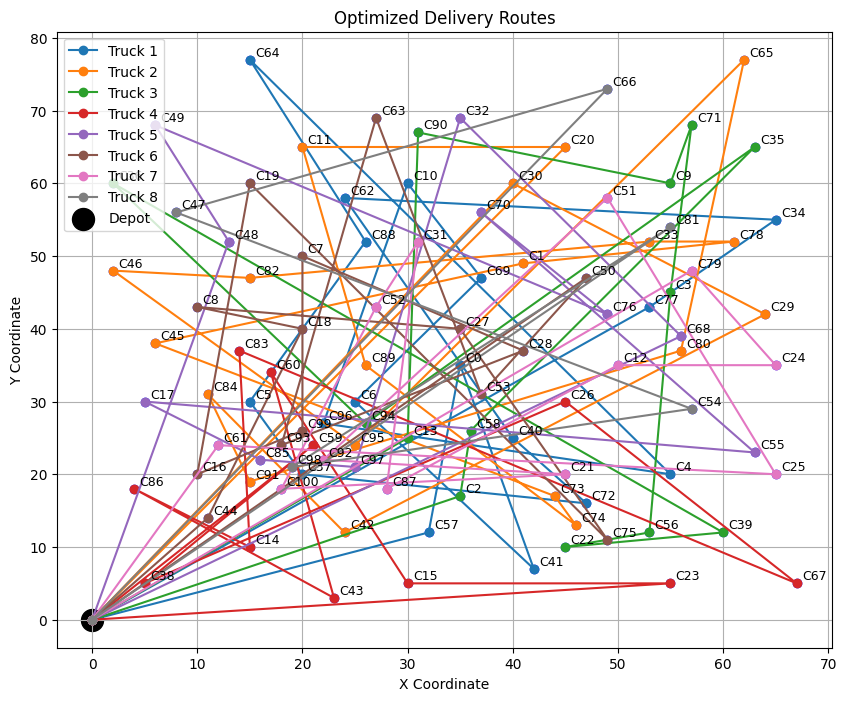

In [ ]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt

# Step 1: Parse Data
def parse_data(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    vehicle_index = next(i for i, line in enumerate(lines) if "VEHICLE" in line)
    max_vehicles = int(lines[vehicle_index + 2].split()[0])  # Number of vehicles
    vehicle_capacity = int(lines[vehicle_index + 2].split()[1])  # Vehicle capacity
    customer_index = next(i for i, line in enumerate(lines) if "CUSTOMER" in line)
    customer_data = []
    for line in lines[customer_index + 2:]:
        if line.strip():
            data = line.split()
            if len(data) == 7:
                customer_data.append({
                    'id': int(data[0]),
                    'x': float(data[1]),
                    'y': float(data[2]),
                    'demand': int(data[3]),
                    'ready_time': int(data[4]),
                    'due_date': int(data[5]),
                    'service_time': int(data[6])
                })
    return max_vehicles, vehicle_capacity, customer_data

# Distance Calculation
def calculate_distance(p1, p2):
    return np.sqrt((p1['x'] - p2['x'])**2 + (p1['y'] - p2['y'])**2)

# Initial Solution
def create_initial_solution(customer_data, max_vehicles, vehicle_capacity):
    customers = customer_data.copy()
    random.shuffle(customers)
    routes = [[] for _ in range(max_vehicles)]
    vehicle_capacities = [vehicle_capacity] * max_vehicles
    for customer in customers:
        assigned = False
        for i in range(max_vehicles):
            if vehicle_capacities[i] >= customer['demand']:
                routes[i].append(customer)
                vehicle_capacities[i] -= customer['demand']
                assigned = True
                break
        if not assigned:
            raise ValueError("Not enough vehicles or capacity to serve all customers.")
    
    return [route for route in routes if route]

# Total Distance Calculation for each truck (individually)
def calculate_individual_truck_details(routes):
    truck_details = []  # To store cost and weight for each truck

    for route in routes:
        if len(route) == 0:
            continue
        
        route_distance = calculate_distance({'x': 0, 'y': 0}, route[0])  # From depot to first customer
        total_weight = sum(customer['demand'] for customer in route)  # Weight when leaving depot
        
        # Calculate the route distance and check if we arrive on time at each customer
        for i in range(len(route) - 1):
            route_distance += calculate_distance(route[i], route[i + 1])
        
        route_distance += calculate_distance(route[-1], {'x': 0, 'y': 0})  # Back to depot
        
        # Store truck details (cost, weight of goods when leaving depot, and weight of goods when returning to depot)
        truck_details.append({
            'cost': route_distance,  # Total distance (cost)
            'weight_out': total_weight,  # Weight of goods when leaving the depot
            'weight_in': 0  # Weight of goods when returning to depot (all goods delivered)
        })

    return truck_details



# Simulated Annealing
def simulated_annealing(customer_data, max_vehicles, vehicle_capacity, initial_temperature=1000, cooling_rate=0.995, iterations=10000):
    current_solution = create_initial_solution(customer_data, max_vehicles, vehicle_capacity)
    truck_details = calculate_individual_truck_details(current_solution)
    
    # If truck_details is empty, it means the solution was infeasible
    if not truck_details:
        return current_solution, truck_details

    best_solution = current_solution
    best_truck_details = truck_details
    best_cost = sum(details['cost'] for details in best_truck_details)  # Sum of individual truck costs

    temperature = initial_temperature
    for _ in range(iterations):
        new_solution = current_solution.copy()
        if len(new_solution) > 1:
            route1, route2 = random.sample(range(len(new_solution)), 2)
            if len(new_solution[route1]) > 0 and len(new_solution[route2]) > 0:
                customer1 = random.choice(new_solution[route1])
                new_solution[route1].remove(customer1)
                if sum(customer['demand'] for customer in new_solution[route2]) + customer1['demand'] <= vehicle_capacity:
                    new_solution[route2].append(customer1)

        # Remove empty routes
        new_solution = [route for route in new_solution if len(route) > 0]

        # Correct any missing customers
        served_customers = {customer['id'] for route in new_solution for customer in route}
        all_customers = {customer['id'] for customer in customer_data}
        missing_customers = all_customers - served_customers

        # Ensure there are enough routes to accommodate missing customers
        for missing_id in missing_customers:
            missing_customer = next(c for c in customer_data if c['id'] == missing_id)
            added = False
            for i in range(len(new_solution)):
                if sum(customer['demand'] for customer in new_solution[i]) + missing_customer['demand'] <= vehicle_capacity:
                    new_solution[i].append(missing_customer)
                    added = True
                    break
            if not added and len(new_solution) < max_vehicles:
                new_solution.append([missing_customer])

        truck_details = calculate_individual_truck_details(new_solution)
        
        # If truck_details is empty, the solution is infeasible
        if not truck_details:
            continue
        
        new_cost = sum(details['cost'] for details in truck_details)  # Sum of individual truck costs

        # Accept new solution based on temperature
        if new_cost < best_cost or random.random() < math.exp((best_cost - new_cost) / temperature):
            current_solution = new_solution
            best_cost = new_cost
            best_truck_details = truck_details

        temperature *= cooling_rate

    return best_solution, best_truck_details

# Print and plot truck details
def print_truck_paths(routes, truck_details):
    for i, (route, details) in enumerate(zip(routes, truck_details)):
        # Print the truck path and details
        customer_ids = [customer['id'] for customer in route]
        print(f"Truck {i + 1} path: Depot -> " + " -> ".join(map(str, customer_ids)) + " -> Depot")
        print(f"  Cost (Distance): {details['cost']:.2f} units")
        print(f"  Weight of goods when leaving depot: {details['weight_out']} units")
        print(f"  Weight of goods when returning to depot: {details['weight_in']} units")
        print()


def plot_routes(routes, customer_data):
    plt.figure(figsize=(10, 8))
    for customer in customer_data:
        plt.scatter(customer['x'], customer['y'], color='blue')
        plt.text(customer['x'] + 0.5, customer['y'] + 0.5, f"C{customer['id']}", fontsize=9)
    for route_idx, route in enumerate(routes):
        route_x = [customer['x'] for customer in route]
        route_y = [customer['y'] for customer in route]
        plt.plot([0] + route_x + [0], [0] + route_y + [0], marker='o', label=f"Truck {route_idx + 1}")
    plt.scatter(0, 0, color='black', marker='o', label="Depot", s=250)
    plt.title("Optimized Delivery Routes")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.legend()
    plt.grid(True)
    plt.show()

# Execute
file_path = "../Dataset/r107.txt"  # Update path as necessary
max_vehicles, vehicle_capacity, customer_data = parse_data(file_path)
best_routes, truck_details = simulated_annealing(customer_data, max_vehicles, vehicle_capacity)

print("\nOptimized Results:")
print(f"Number of Trucks Used: {len(best_routes)}\n")
print_truck_paths(best_routes, truck_details)
plot_routes(best_routes, customer_data)


Dépôt trouvé: {'x': 40.0, 'y': 50.0}, Ready time: 0, Due date: 1236

Optimized Results:
Number of Trucks Used: 10

Truck 1 path: Depot -> 16 -> 75 -> 85 -> 61 -> 86 -> 100 -> 98 -> 60 -> 44 -> 1 -> 9 -> Depot
  Cost (Distance): 283.06 units

Truck 2 path: Depot -> 26 -> 19 -> 29 -> 93 -> 38 -> 3 -> 66 -> 90 -> 10 -> 89 -> 2 -> 99 -> 91 -> Depot
  Cost (Distance): 464.97 units

Truck 3 path: Depot -> 62 -> 18 -> 40 -> 6 -> 96 -> 14 -> 73 -> 33 -> 52 -> 41 -> 35 -> 30 -> 17 -> Depot
  Cost (Distance): 454.83 units

Truck 4 path: Depot -> 13 -> 51 -> 57 -> 76 -> 79 -> 83 -> 53 -> 50 -> 28 -> 42 -> 64 -> 27 -> Depot
  Cost (Distance): 617.85 units

Truck 5 path: Depot -> 8 -> 5 -> 84 -> 94 -> 39 -> 67 -> 69 -> 55 -> 21 -> 37 -> 34 -> 80 -> 49 -> 36 -> Depot
  Cost (Distance): 469.25 units

Truck 6 path: Depot -> 12 -> 54 -> 65 -> 46 -> 82 -> 72 -> 47 -> 56 -> 78 -> Depot
  Cost (Distance): 418.75 units

Truck 7 path: Depot -> 77 -> 45 -> 32 -> 48 -> 70 -> 22 -> 31 -> 87 -> 71 -> 95 -> Depo

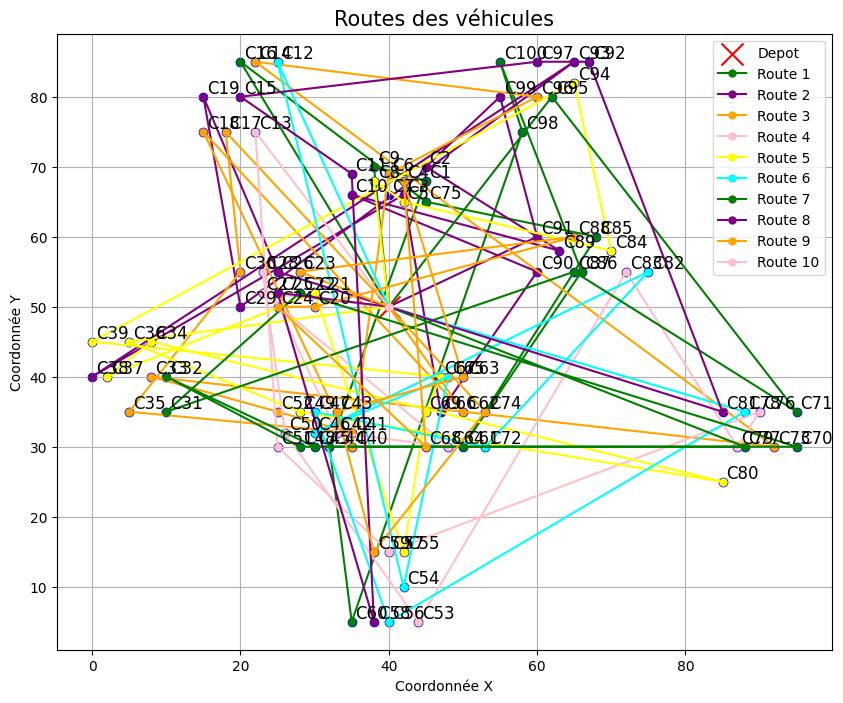

In [ ]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt

# Step 1: Parse Data
def parse_data(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    # Recherche de la ligne contenant "VEHICLE"
    vehicle_index = next(i for i, line in enumerate(lines) if "VEHICLE" in line)
    max_vehicles = int(lines[vehicle_index + 2].split()[0])  # Nombre de véhicules
    vehicle_capacity = int(lines[vehicle_index + 2].split()[1])  # Capacité des véhicules

    # Recherche de la ligne contenant "CUSTOMER"
    customer_index = next(i for i, line in enumerate(lines) if "CUSTOMER" in line)
    
    # Initialisation des variables pour le dépôt
    depot_coords = None
    ready_time = None
    due_date = None
    customer_data = []

    # Parcours des lignes des clients
    for line in lines[customer_index + 2:]:
        data = line.strip().split()
        
        # Si la ligne a les bonnes données (7 éléments), traiter les informations
        if len(data) == 7:
            customer_id = int(data[0])
            xcoord = float(data[1])
            ycoord = float(data[2])
            demand = int(data[3])
            ready_time_cust = int(data[4])
            due_date_cust = int(data[5])
            service_time = int(data[6])
            
            # Si c'est la ligne du dépôt (id == 0), on prend ces valeurs
            if customer_id == 0:
                depot_coords = {'x': xcoord, 'y': ycoord}
                ready_time = ready_time_cust
                due_date = due_date_cust
                print(f"Dépôt trouvé: {depot_coords}, Ready time: {ready_time}, Due date: {due_date}")
            else:
                # Sinon, c'est un client classique
                customer_data.append({
                    'id': customer_id,
                    'x': xcoord,
                    'y': ycoord,
                    'demand': demand,
                    'ready_time': ready_time_cust,
                    'due_date': due_date_cust,
                    'service_time': service_time
                })

    # Vérification si le dépôt a été trouvé
    if depot_coords is None:
        raise ValueError("Coordonnées du dépôt manquantes ou incorrectes dans le fichier.")
    
    # Retourner les informations : coordonnées du dépôt, horaires, et les données des clients
    return depot_coords, ready_time, due_date, max_vehicles, vehicle_capacity, customer_data

# Distance Calculation
def calculate_distance(p1, p2):
    return np.sqrt((p1['x'] - p2['x'])**2 + (p1['y'] - p2['y'])**2)

# Initial Solution
def create_initial_solution(customer_data, max_vehicles, vehicle_capacity):
    customers = customer_data.copy()
    random.shuffle(customers)
    routes = [[] for _ in range(max_vehicles)]
    vehicle_capacities = [vehicle_capacity] * max_vehicles
    for customer in customers:
        assigned = False
        for i in range(max_vehicles):
            if vehicle_capacities[i] >= customer['demand']:
                routes[i].append(customer)
                vehicle_capacities[i] -= customer['demand']
                assigned = True
                break
        if not assigned:
            raise ValueError("Not enough vehicles or capacity to serve all customers.")
    return [route for route in routes if route]

# Total Distance Calculation for each truck (individually)
def calculate_individual_truck_details(routes, depot_coords, ready_time, due_date):
    truck_details = []
    for route in routes:
        current_time = ready_time  # Commencer à l'heure d'ouverture du dépôt
        for i in range(len(route) - 1):
            # Calcul du temps entre les clients
            travel_time = calculate_distance(route[i], route[i + 1])  # Calculez le temps de trajet
            current_time += travel_time  # Ajoutez le temps de trajet à l'heure actuelle

            # Vérifier si le client peut être servi à temps
            if current_time > route[i + 1]['due_date']:
                raise ValueError(f"Temps dépassé pour le client {route[i + 1]['id']}.")
            
        # Retour au dépôt
        return_time = calculate_distance(route[-1], depot_coords)
        current_time += return_time
        truck_details.append({
            'route': route,
            'final_time': current_time
        })
    return truck_details

# Check if the solution is valid (all customers served within their time windows)
def is_solution_valid(routes, depot_coords, ready_time, due_date):
    current_time = ready_time
    for route in routes:
        for i in range(len(route) - 1):
            travel_time = calculate_distance(route[i], route[i + 1])
            current_time += travel_time

            # Vérifier si l'heure actuelle dépasse le due_date
            if current_time > route[i + 1]['due_date']:
                return False  # La solution est invalide si on dépasse le due_date

            current_time += route[i + 1]['service_time']  # Ajouter le temps de service

        # Retour au dépôt
        return_time = calculate_distance(route[-1], depot_coords)
        current_time += return_time

    return True  # Si tous les clients sont servis dans les délais, la solution est valide

# Simulated Annealing
def simulated_annealing(customer_data, depot_coords, ready_time, due_date, max_vehicles, vehicle_capacity, initial_temperature=1000, cooling_rate=0.995, iterations=10000):
    current_solution = create_initial_solution(customer_data, max_vehicles, vehicle_capacity)
    truck_details = calculate_individual_truck_details(current_solution, depot_coords, ready_time, due_date)

    best_solution = current_solution
    best_truck_details = truck_details
    best_cost = sum(details['final_time'] for details in best_truck_details)

    temperature = initial_temperature
    for _ in range(iterations):
        new_solution = current_solution.copy()
        if len(new_solution) > 1:
            route1, route2 = random.sample(range(len(new_solution)), 2)
            if len(new_solution[route1]) > 0 and len(new_solution[route2]) > 0:
                customer1 = random.choice(new_solution[route1])
                new_solution[route1].remove(customer1)
                if sum(customer['demand'] for customer in new_solution[route2]) + customer1['demand'] <= vehicle_capacity:
                    new_solution[route2].append(customer1)

        # Remove empty routes
        new_solution = [route for route in new_solution if len(route) > 0]

        # Ensure all customers are served
        served_customers = {customer['id'] for route in new_solution for customer in route}
        all_customers = {customer['id'] for customer in customer_data}
        missing_customers = all_customers - served_customers
        for missing_id in missing_customers:
            missing_customer = next(c for c in customer_data if c['id'] == missing_id)
            added = False
            for i in range(len(new_solution)):
                if sum(customer['demand'] for customer in new_solution[i]) + missing_customer['demand'] <= vehicle_capacity:
                    new_solution[i].append(missing_customer)
                    added = True
                    break
            if not added and len(new_solution) < max_vehicles:
                new_solution.append([missing_customer])

        # Vérifier si la solution est valide avant de l'accepter
        if is_solution_valid(new_solution, depot_coords, ready_time, due_date):
            truck_details = calculate_individual_truck_details(new_solution, depot_coords, ready_time, due_date)
            new_cost = sum(details['final_time'] for details in truck_details)

            if new_cost < best_cost or random.random() < math.exp((best_cost - new_cost) / temperature):
                current_solution = new_solution
                best_cost = new_cost
                best_truck_details = truck_details

        temperature *= cooling_rate

    return best_solution, best_truck_details

# Print and plot truck details
def print_truck_paths(routes, truck_details):
    for i, (route, details) in enumerate(zip(routes, truck_details)):
        customer_ids = [customer['id'] for customer in route]
        print(f"Truck {i + 1} path: Depot -> " + " -> ".join(map(str, customer_ids)) + " -> Depot")
        print(f"  Cost (Distance): {details['final_time']:.2f} units")
        print()

def plot_routes(routes, depot_coords, customer_data):
    plt.figure(figsize=(10, 8))
    plt.scatter(depot_coords['x'], depot_coords['y'], color='red', marker='x', label="Depot", s=250)
    for customer in customer_data:
        plt.scatter(customer['x'], customer['y'], color='blue')
        plt.text(customer['x'] + 0.5, customer['y'] + 0.5, f"C{customer['id']}", fontsize=12)

    colors = ['green', 'purple', 'orange', 'pink', 'yellow', 'cyan']
    for i, route in enumerate(routes):
        color = colors[i % len(colors)]
        route_coords = [(depot_coords['x'], depot_coords['y'])] + [(customer['x'], customer['y']) for customer in route] + [(depot_coords['x'], depot_coords['y'])]
        route_coords = np.array(route_coords)
        plt.plot(route_coords[:, 0], route_coords[:, 1], color=color, marker='o', markersize=5, label=f"Route {i + 1}")
    
    plt.title("Routes des véhicules", fontsize=15)
    plt.xlabel("Coordonnée X")
    plt.ylabel("Coordonnée Y")
    plt.legend()
    plt.grid(True)
    plt.show()

# Execute
file_path = "../Dataset/c102.txt"  # Update path as necessary

# Parse data from the file
depot_coords, ready_time, due_date, max_vehicles, vehicle_capacity, customer_data = parse_data(file_path)

# Run simulated annealing algorithm to find the best routes
best_routes, truck_details = simulated_annealing(customer_data, depot_coords, ready_time, due_date, max_vehicles, vehicle_capacity)

# Output the results
print("\nOptimized Results:")
print(f"Number of Trucks Used: {len(best_routes)}\n")
print_truck_paths(best_routes, truck_details)

# Plot the routes on a graph
plot_routes(best_routes, depot_coords, customer_data)


In [ ]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt


# Step 1: Parse Data
def parse_data(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    # Recherche de la ligne contenant "VEHICLE"
    vehicle_index = next(i for i, line in enumerate(lines) if "VEHICLE" in line)
    max_vehicles = int(lines[vehicle_index + 2].split()[0])  # Nombre de véhicules
    vehicle_capacity = int(lines[vehicle_index + 2].split()[1])  # Capacité des véhicules

    # Recherche de la ligne contenant "CUSTOMER"
    customer_index = next(i for i, line in enumerate(lines) if "CUSTOMER" in line)
    
    # Initialisation des variables pour le dépôt
    depot_coords = None
    ready_time = None
    due_date = None
    customer_data = []

    # Parcours des lignes des clients
    for line in lines[customer_index + 2:]:
        data = line.strip().split()
        
        # Si la ligne a les bonnes données (7 éléments), traiter les informations
        if len(data) == 7:
            customer_id = int(data[0])
            xcoord = float(data[1])
            ycoord = float(data[2])
            demand = int(data[3])
            ready_time_cust = int(data[4])
            due_date_cust = int(data[5])
            service_time = int(data[6])
            
            # Si c'est la ligne du dépôt (id == 0), on prend ces valeurs
            if customer_id == 0:
                depot_coords = {'x': xcoord, 'y': ycoord}
                ready_time = ready_time_cust
                due_date = due_date_cust
                print(f"Dépôt trouvé: {depot_coords}, Ready time: {ready_time}, Due date: {due_date}")
            else:
                # Sinon, c'est un client classique
                customer_data.append({
                    'id': customer_id,
                    'x': xcoord,
                    'y': ycoord,
                    'demand': demand,
                    'ready_time': ready_time_cust,
                    'due_date': due_date_cust,
                    'service_time': service_time
                })

    # Vérification si le dépôt a été trouvé
    if depot_coords is None:
        raise ValueError("Coordonnées du dépôt manquantes ou incorrectes dans le fichier.")
    
    # Retourner les informations : coordonnées du dépôt, horaires, et les données des clients
    return depot_coords, ready_time, due_date, max_vehicles, vehicle_capacity, customer_data


# Distance Calculation
def calculate_distance(p1, p2):
    return np.sqrt((p1['x'] - p2['x'])**2 + (p1['y'] - p2['y'])**2)

# Vérifier si la solution est valide (en tenant compte des horaires de service)
def is_solution_valid(routes, depot_coords, ready_time, due_date):
    current_time = ready_time  # Commencer à l'heure d'ouverture du dépôt
    
    for route in routes:
        current_time = ready_time  # Réinitialiser l'heure pour chaque itinéraire
        for i in range(len(route)):
            customer = route[i]

            # Vérifier si l'heure d'arrivée dépasse le due_date du client (en minutes)
            if current_time > customer['due_date']:
                return False  # La solution est invalide si on dépasse le due_date

            # Appliquer le temps de service
            current_time += customer['service_time']

            # Si ce n'est pas le dernier client de l'itinéraire, calculer le temps de trajet jusqu'au suivant
            if i < len(route) - 1:
                next_customer = route[i + 1]
                travel_time = calculate_distance(customer, next_customer)  # en minutes
                current_time += travel_time  # Ajouter le temps de trajet pour le client suivant

        # Retour au dépôt
        return_time = calculate_distance(route[-1], depot_coords)  # en minutes
        current_time += return_time
        if current_time > due_date:
            return False  # Si le temps dépasse la date limite à la fin du trajet
    return True  # Si tous les clients sont servis dans les délais

# Création de la solution initiale
def create_initial_solution(customer_data, max_vehicles, vehicle_capacity):
    customers = customer_data.copy()
    random.shuffle(customers)
    routes = [[] for _ in range(max_vehicles)]
    vehicle_capacities = [vehicle_capacity] * max_vehicles
    for customer in customers:
        assigned = False
        for i in range(max_vehicles):
            if vehicle_capacities[i] >= customer['demand']:
                routes[i].append(customer)
                vehicle_capacities[i] -= customer['demand']
                assigned = True
                break
        if not assigned:
            raise ValueError("Not enough vehicles or capacity to serve all customers.")
    return [route for route in routes if route]

# Simulated Annealing
def simulated_annealing(customer_data, depot_coords, ready_time, due_date, max_vehicles, vehicle_capacity, initial_temperature=1000, cooling_rate=0.995, iterations=10000):
    current_solution = create_initial_solution(customer_data, max_vehicles, vehicle_capacity)
    truck_details = calculate_individual_truck_details(current_solution, depot_coords, ready_time, due_date)

    best_solution = current_solution
    best_truck_details = truck_details
    best_cost = sum(details['final_time'] for details in best_truck_details)

    temperature = initial_temperature
    for _ in range(iterations):
        new_solution = current_solution.copy()

        # Échange aléatoire de clients entre les itinéraires
        if len(new_solution) > 1:
            route1, route2 = random.sample(range(len(new_solution)), 2)
            if len(new_solution[route1]) > 0 and len(new_solution[route2]) > 0:
                customer1 = random.choice(new_solution[route1])
                new_solution[route1].remove(customer1)
                if sum(customer['demand'] for customer in new_solution[route2]) + customer1['demand'] <= vehicle_capacity:
                    new_solution[route2].append(customer1)

        # Remove empty routes
        new_solution = [route for route in new_solution if len(route) > 0]

        # Ensure all customers are served
        served_customers = {customer['id'] for route in new_solution for customer in route}
        all_customers = {customer['id'] for customer in customer_data}
        missing_customers = all_customers - served_customers
        for missing_id in missing_customers:
            missing_customer = next(c for c in customer_data if c['id'] == missing_id)
            added = False
            for i in range(len(new_solution)):
                if sum(customer['demand'] for customer in new_solution[i]) + missing_customer['demand'] <= vehicle_capacity:
                    new_solution[i].append(missing_customer)
                    added = True
                    break
            if not added and len(new_solution) < max_vehicles:
                new_solution.append([missing_customer])

        # Vérifier si la solution est valide avant de l'accepter
        if is_solution_valid(new_solution, depot_coords, ready_time, due_date):
            truck_details = calculate_individual_truck_details(new_solution, depot_coords, ready_time, due_date)
            new_cost = sum(details['final_time'] for details in truck_details)

            if new_cost < best_cost or random.random() < math.exp((best_cost - new_cost) / temperature):
                current_solution = new_solution
                best_cost = new_cost
                best_truck_details = truck_details

        temperature *= cooling_rate

    return best_solution, best_truck_details


# Affichage des détails des trajets
def print_truck_paths(routes, truck_details):
    for i, (route, details) in enumerate(zip(routes, truck_details)):
        customer_ids = [customer['id'] for customer in route]
        print(f"Camion {i + 1} trajet: Dépôt -> " + " -> ".join(map(str, customer_ids)) + " -> Dépôt")
        print(f"  Temps total (Distance): {details['final_time']:.2f} minutes")
        print(f"  Poids des marchandises au départ du dépôt: {sum(c['demand'] for c in route)} unités")
        print(f"  Poids des marchandises à l'arrivée au dépôt: {sum(c['demand'] for c in route)} unités")
        print()

# Tracer les routes sur un graphique
def plot_routes(routes, depot_coords, customer_data):
    plt.figure(figsize=(10, 8))
    plt.scatter(depot_coords['x'], depot_coords['y'], color='red', marker='x', label="Dépôt", s=250)
    for customer in customer_data:
        plt.scatter(customer['x'], customer['y'], color='blue')
        plt.text(customer['x'] + 0.5, customer['y'] + 0.5, f"C{customer['id']}", fontsize=12)

    colors = ['green', 'purple', 'orange', 'pink', 'yellow', 'cyan']
    for i, route in enumerate(routes):
        color = colors[i % len(colors)]
        route_coords = [(depot_coords['x'], depot_coords['y'])] + [(customer['x'], customer['y']) for customer in route] + [(depot_coords['x'], depot_coords['y'])]
        route_coords = np.array(route_coords)
        plt.plot(route_coords[:, 0], route_coords[:, 1], color=color, marker='o', markersize=5, label=f"Route {i + 1}")
    
    plt.title("Routes des véhicules", fontsize=15)
    plt.xlabel("Coordonnée X")
    plt.ylabel("Coordonnée Y")
    plt.legend()
    plt.grid(True)
    plt.show()

# Charger les données et exécuter
file_path = "../Dataset/c101.txt"  # Chemin du fichier de données

# Parse data from the file
depot_coords, ready_time, due_date, max_vehicles, vehicle_capacity, customer_data = parse_data(file_path)

# Run simulated annealing algorithm to find the best routes
best_routes, truck_details = simulated_annealing(customer_data, depot_coords, ready_time, due_date, max_vehicles, vehicle_capacity)

# Output the results
print("\nOptimized Results:")
print(f"Number of Trucks Used: {len(best_routes)}\n")
print_truck_paths(best_routes, truck_details)

# Plot the routes on a graph
plot_routes(best_routes, depot_coords, customer_data)

Dépôt trouvé: {'x': 40.0, 'y': 50.0}, Ready time: 0, Due date: 1236


ValueError: Temps dépassé pour le client 57.